# HVAC vs Temperature
Steve Smith
Dec 2024
* The goal of this is to predict HVAC usage for a given outdoor temp. 
* This could help determine how much more money is spent for a given temp difference or if there are inefficiences in HVAC. 

There are two sources for this data to combine: 
1. Historical outdoor temperatures for the past year
2. Historical heating and cooling system usage provided by NEST
Need to add a document on how this was obtainied

## Load modules and data

In [1]:
import pandas as pd
from plotnine import ggplot,aes,geom_point,geom_line,geom_abline,ylab,xlab
from sklearn.linear_model import LinearRegression
import numpy as np


In [2]:
date_format="%Y-%m-%d"
DATA_DIR="~/Documents/"
WEATHER_DATA= f"{DATA_DIR}weather.tsv" 
HVAC_USAGE= f"{DATA_DIR}energy_use.tsv" 

# Data from National Weather 
weather=pd.read_csv(WEATHER_DATA,sep="\t")
weather_long=pd.melt(weather,id_vars=["Unnamed: 0","STATION","DATE"])
# convert to date format
weather_long['DATE']=pd.to_datetime(weather_long['DATE'],format=date_format)
display(weather_long)

# Data from NEST
#TODO: replace with new json data! 
energy_use=pd.read_csv(HVAC_USAGE,sep="\t")
energy_use['use_mins']=energy_use['data']/60
energy_use['asDATE']=pd.to_datetime(energy_use['start'],format="ISO8601")
energy_use['DATE']=pd.to_datetime(energy_use['asDATE']).dt.strftime(date_format)
energy_use['asDATE']=pd.to_datetime(energy_use['asDATE'],format=date_format)

display(energy_use)

# HVAC state map, split out factors into their own variables
hvac_state_map = pd.read_csv("/Users/stevensmith/Projects/Random_Projects/hvac_usage/hvac_type_map.tsv",sep="\t")


,Unnamed: 0,STATION,DATE,variable,value
0,41494,USW00013739,2023-01-01,TAVG,51.0
1,41495,USW00013739,2023-01-02,TAVG,46.0
2,41496,USW00013739,2023-01-03,TAVG,52.0
3,41497,USW00013739,2023-01-04,TAVG,59.0
4,41498,USW00013739,2023-01-05,TAVG,58.0
...,...,...,...,...,...
1707,41917,USW00013739,2024-02-28,TOBS,NaN
1708,41918,USW00013739,2024-02-29,TOBS,NaN
1709,41919,USW00013739,2024-03-01,TOBS,NaN
1710,41920,USW00013739,2024-03-02,TOBS,NaN


,Unnamed: 0,start,stop,type,data,use_mins,asDATE,DATE
0,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2023-04-09 04:00:00+00:00,2023-04-09
1,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,21360,356.0,2023-04-09 04:00:00+00:00,2023-04-09
2,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,29400,490.0,2023-04-09 04:00:00+00:00,2023-04-09
3,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,180,3.0,2023-04-10 04:00:00+00:00,2023-04-10
4,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,19500,325.0,2023-04-10 04:00:00+00:00,2023-04-10
...,...,...,...,...,...,...,...,...
958,0,2024-03-04T05:00:00Z,2024-03-05T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,8430,140.5,2024-03-04 05:00:00+00:00,2024-03-04
959,0,2024-03-04T05:00:00Z,2024-03-05T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,22980,383.0,2024-03-04 05:00:00+00:00,2024-03-04
960,0,2024-03-05T05:00:00Z,2024-03-06T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2024-03-05 05:00:00+00:00,2024-03-05
961,0,2024-03-05T05:00:00Z,2024-03-06T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,14340,239.0,2024-03-05 05:00:00+00:00,2024-03-05


In [7]:
energy_use['date2'] = pd.to_datetime(energy_use['start']).dt.date
energy_use

,Unnamed: 0,start,stop,type,data,use_mins,date2
0,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2023-04-09
1,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,21360,356.0,2023-04-09
2,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,29400,490.0,2023-04-09
3,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,180,3.0,2023-04-10
4,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,19500,325.0,2023-04-10
...,...,...,...,...,...,...,...
958,0,2024-03-04T05:00:00Z,2024-03-05T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,8430,140.5,2024-03-04
959,0,2024-03-04T05:00:00Z,2024-03-05T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,22980,383.0,2024-03-04
960,0,2024-03-05T05:00:00Z,2024-03-06T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2024-03-05
961,0,2024-03-05T05:00:00Z,2024-03-06T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,14340,239.0,2024-03-05


## Plots
### Outdoor temp vs date
* Weather data includes avg temp, max and min for the weather station in F
* As ecpected the temp is max in summer and min in winter; there are also intra-day fluxuations
* For HVAC data, will use TAVG as the representative temp for the day

/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 431 rows containing missing values.
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 428 rows containing missing values.


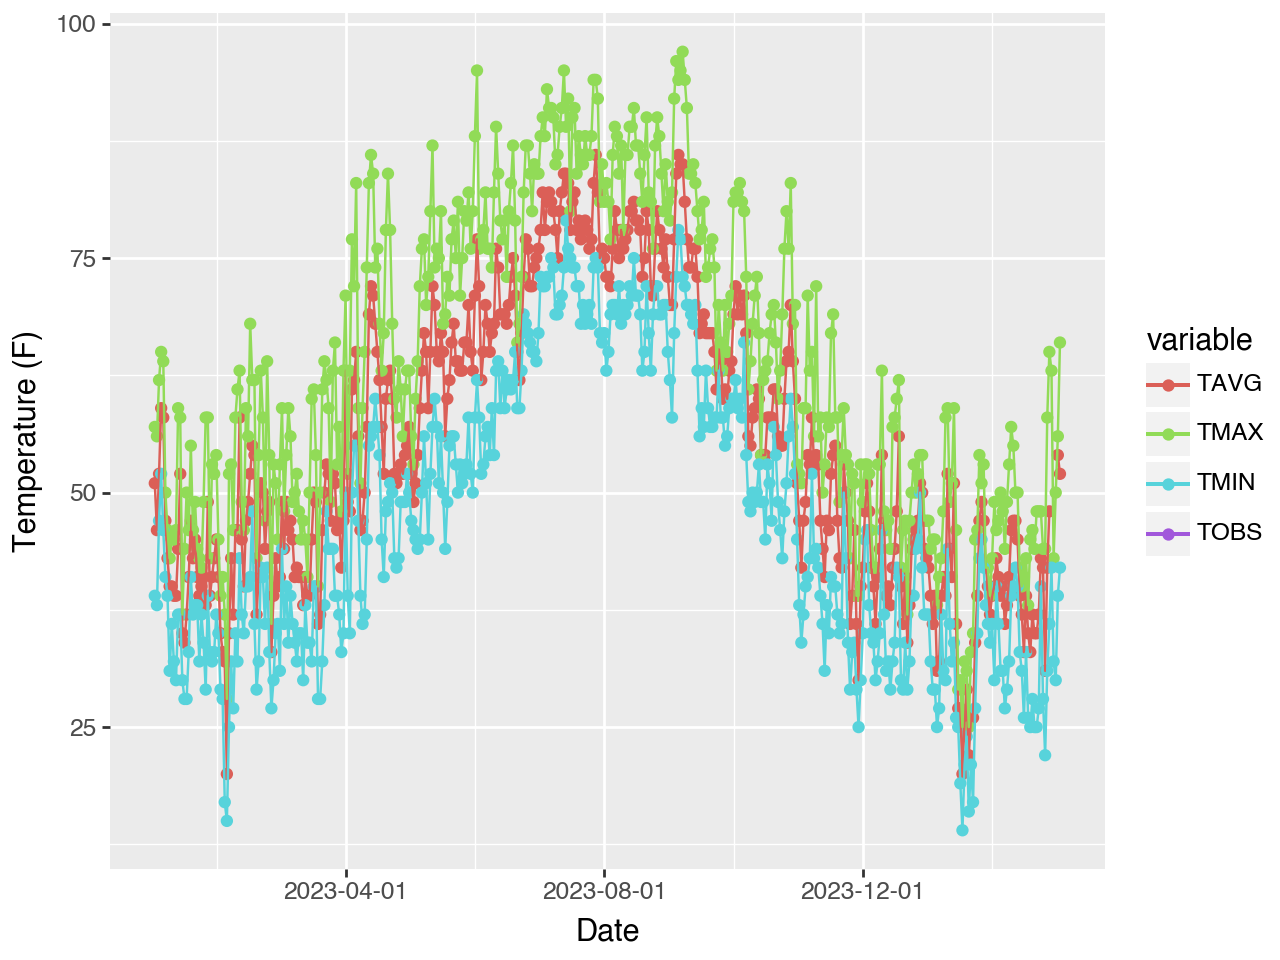

In [23]:

(ggplot(weather_long,aes("DATE","value",color="variable"))+
 geom_point()+
 geom_line()+
 ylab("Temperature (F)")+
 xlab("Date"))


### HVAC usage from year
* Data as reported from NEST for heat, cool and leaf
* General correlation of heating in winter, cooling in summer with other non correlative points
* NEST also has "leaf" which is not all that useful
* My HVAC system has multiple fuel types and modes which are not captured here (just heat or cool)

In [29]:
type(energy_use['DATE'][0])

str

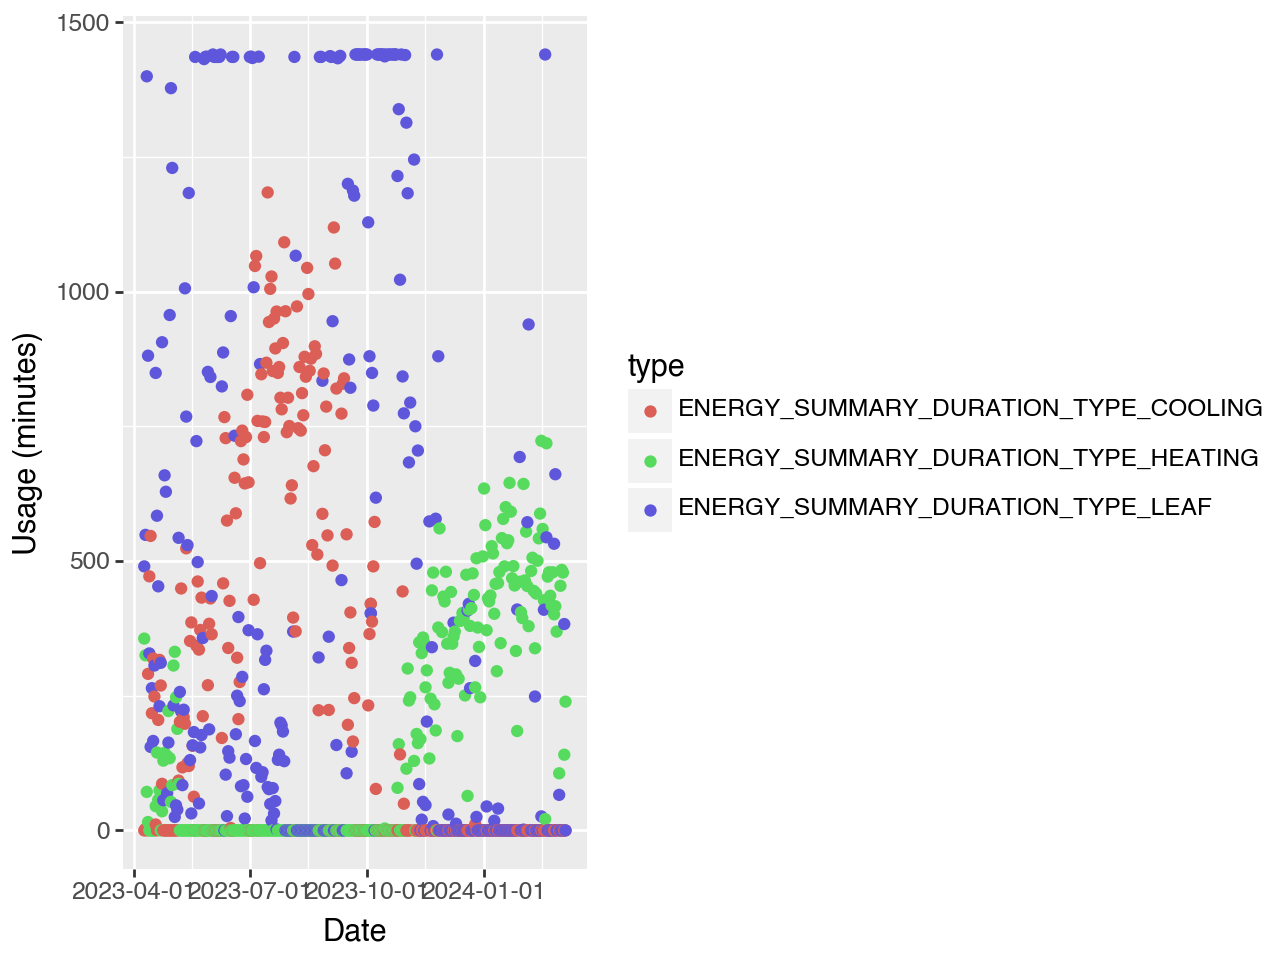

In [30]:
(ggplot(energy_use,aes("asDATE","use_mins",color="type"))+
 geom_point()+
 ylab("Usage (minutes)")+
 xlab("Date"))


### Join HVAC usage and avg daily temp
* Join the HVAC data with the avg daily temp based on date
* HVAC was not used every day

In [31]:
energy_weather=pd.merge(weather,energy_use,on="DATE")
energy_weather


,Unnamed: 0_x,STATION,DATE,TAVG,TMAX,TMIN,TOBS,Unnamed: 0_y,start,stop,type,data,use_mins,asDATE
0,41592,USW00013739,2023-04-09,47.0,59.0,36.0,NaN,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2023-04-09 04:00:00+00:00
1,41592,USW00013739,2023-04-09,47.0,59.0,36.0,NaN,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,21360,356.0,2023-04-09 04:00:00+00:00
2,41592,USW00013739,2023-04-09,47.0,59.0,36.0,NaN,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,29400,490.0,2023-04-09 04:00:00+00:00
3,41593,USW00013739,2023-04-10,50.0,65.0,37.0,NaN,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,180,3.0,2023-04-10 04:00:00+00:00
4,41593,USW00013739,2023-04-10,50.0,65.0,37.0,NaN,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,19500,325.0,2023-04-10 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,41920,USW00013739,2024-03-02,54.0,56.0,39.0,NaN,0,2024-03-02T05:00:00Z,2024-03-03T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,29010,483.5,2024-03-02 05:00:00+00:00
953,41920,USW00013739,2024-03-02,54.0,56.0,39.0,NaN,0,2024-03-02T05:00:00Z,2024-03-03T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,0,0.0,2024-03-02 05:00:00+00:00
954,41921,USW00013739,2024-03-03,52.0,66.0,42.0,NaN,0,2024-03-03T05:00:00Z,2024-03-04T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2024-03-03 05:00:00+00:00
955,41921,USW00013739,2024-03-03,52.0,66.0,42.0,NaN,0,2024-03-03T05:00:00Z,2024-03-04T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,28710,478.5,2024-03-03 05:00:00+00:00


### Linear model of HVAC vs temp


In [61]:

def comptue_lm(df_in):
    usage_model = LinearRegression()
    usage_model.fit(np.array(df_in['TAVG']).reshape(-1, 1), np.array(df_in['use_mins']))
    # Lm fits
    lm_results={'slope':usage_model.coef_[0],'yint':usage_model.intercept_,'fit_model':usage_model}
    print(f"Fitted Usage equation: {lm_results['slope']} x Tavg + {lm_results['yint']}")

    return lm_results

lm_in_cool=energy_weather[(energy_weather['type']=="ENERGY_SUMMARY_DURATION_TYPE_COOLING") & (energy_weather['use_mins']>0)]
lm_in_heat=energy_weather[(~energy_weather['TAVG'].isna()) &(energy_weather['type']=="ENERGY_SUMMARY_DURATION_TYPE_HEATING") & (energy_weather['use_mins']>0)]

lm_res_cool=comptue_lm(lm_in_cool)
lm_res_heat=comptue_lm(lm_in_heat)




Fitted Usage equation: 34.053364170105894 x Tavg + -1895.4648937205343
Fitted Usage equation: -12.303180928162043 x Tavg + 898.1996421696108


/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 6 rows containing missing values.


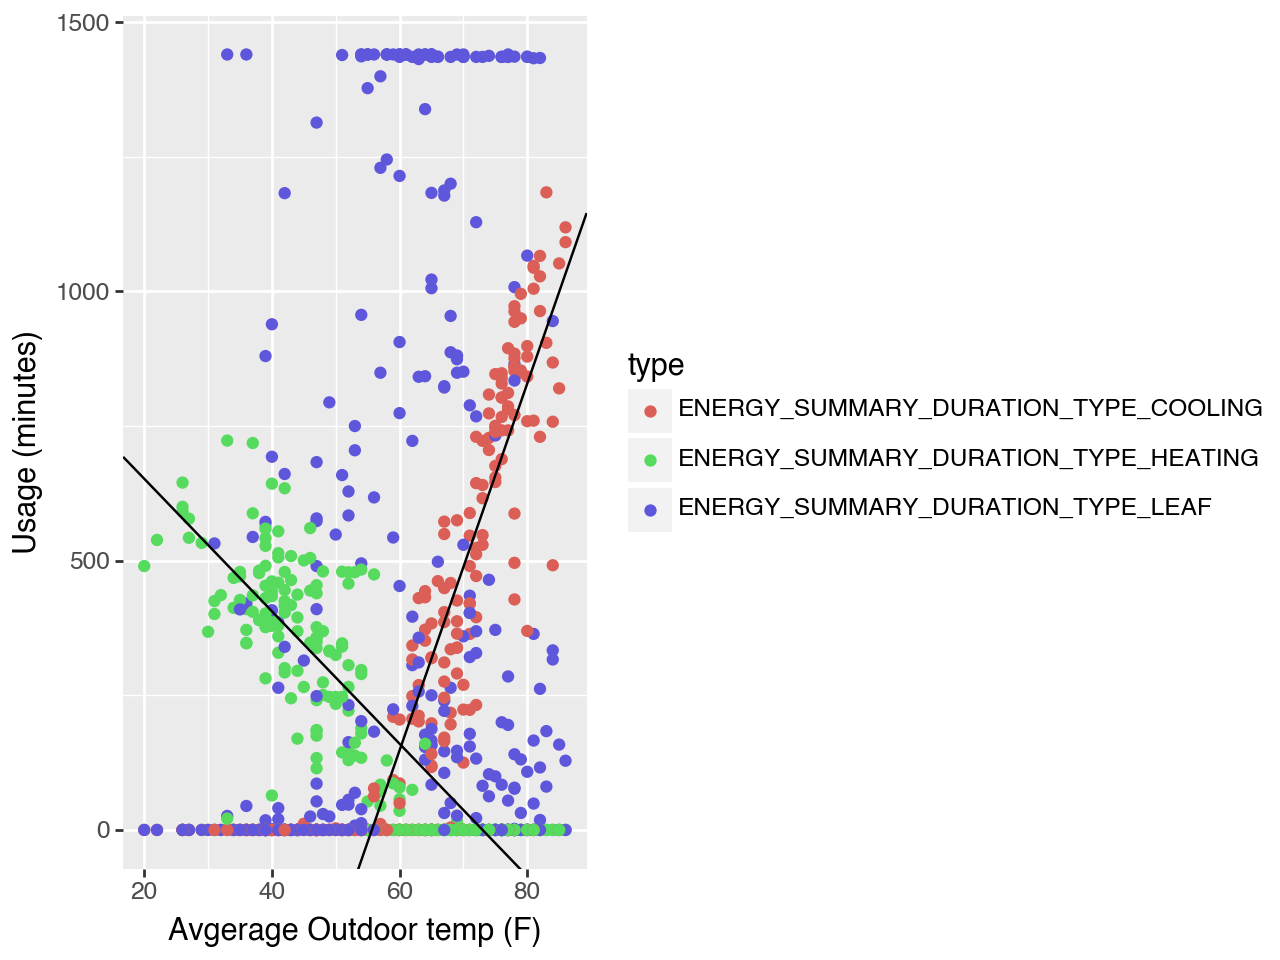

In [59]:
(ggplot(energy_weather,aes("TAVG","use_mins",color="type"))+geom_point()+
  geom_abline(slope=lm_res_cool['slope'],intercept = lm_res_cool['yint'])+
  geom_abline(slope=lm_res_heat['slope'],intercept = lm_res_heat['yint'])+
  ylab("Usage (minutes)")+
  xlab("Avgerage Outdoor temp (F)"))

## Predictions
* From the lm models above, I can predict how much heat or cool usage for a given outside temp


In [72]:

# How many hours does heat run on a 30, 40 & 50 degree day?
display(lm_res_heat['fit_model'].predict(np.array([30,40,50]).reshape(-1,1))/60)

# How many hours does A/C run on a 70,80,90 degree day?
display(lm_res_cool['fit_model'].predict(np.array([70,80,90]).reshape(-1,1))/60)




array([8.81840357, 6.76787342, 4.71734326])

array([ 8.1378433 , 13.813404  , 19.48896469])

# Load NEST json, convert to table

In [ ]:
with open('/Users/stevensmith/Projects/Random_Projects/hvac_usage/HomeHistory.json', 'r') as file:
    data = json.load(file)


# NEST provides data for all houses on account as an array within 'structure_history'
# index 0 is beach house, 
# index 1 is my house, 
# index 2 is Parent's house
# Look at my house, index 1, for now
#TODO: add a structure of json 
normalized_df=pd.json_normalize(data['structure_history'][1],'events',['structure_name']) 
normalized_df


# Load setpoints
Unfortunatley this does not include ALL set points, only head for November? 
Unsure why 

In [ ]:
normalized_df['event.event_data.setpoint_type'].drop_duplicates()

# Cut down to HVAC states only
Fitler columns and rows to contain only the HVAC state==True type of data
Convert to long, where the different HVAC states are listed long-wise

In [142]:
val_vars=["event.event_data.hvac_state.alternate_heat_stage_1_active","event.event_data.prior_hvac_state.alternate_heat_stage_2_active","event.event_data.hvac_state.alternate_heat_stage_2_active","event.event_data.prior_hvac_state.heat_stage_1_active","event.event_data.hvac_state.heat_stage_1_active","event.event_data.prior_hvac_state.heat_stage_2_active","event.event_data.hvac_state.heat_stage_2_active","event.event_data.prior_hvac_state.cool_stage_1_active","event.event_data.hvac_state.cool_stage_1_active","event.event_data.prior_hvac_state.cool_stage_2_active","event.event_data.hvac_state.cool_stage_2_active"]
normalized_df_long=pd.melt(normalized_df,
        id_vars=["timestamp","event.event_header.wdm_event_fields.event_id","event.event_header.service_timestamps.salt","event.event_header.subject.trait_instance_label"],
        value_vars=val_vars,var_name="HVAC_state",value_name="activated")

normalized_df_long=normalized_df_long[~normalized_df_long["activated"].isna()]

normalized_df_long

,timestamp,event.event_header.wdm_event_fields.event_id,event.event_header.service_timestamps.salt,event.event_header.subject.trait_instance_label,HVAC_state,activated
248,2025-01-08T01:41:53.887Z,478782,2025-01-08T01:41:54.044Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True
250,2025-01-08T01:06:40.741Z,478779,2025-01-08T01:06:40.858Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True
252,2025-01-08T00:34:27.661Z,478776,2025-01-08T00:34:27.818Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True
254,2025-01-08T00:04:16.704Z,478773,2025-01-08T00:04:16.830Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True
256,2025-01-07T23:32:33.518Z,478770,2025-01-07T23:32:33.670Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True
...,...,...,...,...,...,...
320301,2023-04-13T18:57:52.974Z,458889,2023-04-13T20:25:53.105Z,hvac_control,event.event_data.hvac_state.cool_stage_2_active,True
320308,2023-04-13T01:19:53.482Z,458865,2023-04-13T01:19:53.192Z,hvac_control,event.event_data.hvac_state.cool_stage_2_active,True
320321,2023-04-12T21:17:17.442Z,458854,2023-04-13T01:00:57.449Z,hvac_control,event.event_data.hvac_state.cool_stage_2_active,True
320322,2023-04-12T21:17:17.442Z,458854,2023-04-12T21:17:17.391Z,hvac_control,event.event_data.hvac_state.cool_stage_2_active,True


# Format and sort

In [145]:
# Convert timestap
normalized_df_long['timestamp_formatted']=normalized_df_long['timestamp'].str.replace('Z', '+00:00').apply(lambda x: datetime.fromisoformat(x))

# Important to sort by day for next steps
normalized_df_long=normalized_df_long.sort_values(by='timestamp_formatted',ascending=True)
nrow=normalized_df_long.shape[0]

# also important to have the sorted df index 1...nrows
normalized_df_long=normalized_df_long.reset_index(drop=True)
normalized_df_long

,timestamp,event.event_header.wdm_event_fields.event_id,event.event_header.service_timestamps.salt,event.event_header.subject.trait_instance_label,HVAC_state,activated,timestamp_formatted
0,2023-04-08T15:34:10.911Z,262147,2023-04-08T15:34:11.024Z,hvac_control,event.event_data.hvac_state.heat_stage_1_active,True,2023-04-08 15:34:10.911000+00:00
1,2023-04-08T15:34:38.939Z,262148,2023-04-08T15:34:39.040Z,hvac_control,event.event_data.prior_hvac_state.heat_stage_1...,True,2023-04-08 15:34:38.939000+00:00
2,2023-04-08T16:47:42.244Z,327686,2023-04-08T16:47:42.307Z,hvac_control,event.event_data.hvac_state.heat_stage_1_active,True,2023-04-08 16:47:42.244000+00:00
3,2023-04-08T16:50:44.218Z,327687,2023-04-08T16:50:44.279Z,hvac_control,event.event_data.prior_hvac_state.heat_stage_1...,True,2023-04-08 16:50:44.218000+00:00
4,2023-04-08T16:53:13.858Z,327688,2023-04-08T16:53:13.922Z,hvac_control,event.event_data.hvac_state.heat_stage_2_active,True,2023-04-08 16:53:13.858000+00:00
...,...,...,...,...,...,...,...
13857,2025-01-07T23:32:33.518Z,478770,2025-01-07T23:32:33.670Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True,2025-01-07 23:32:33.518000+00:00
13858,2025-01-08T00:04:16.704Z,478773,2025-01-08T00:04:16.830Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True,2025-01-08 00:04:16.704000+00:00
13859,2025-01-08T00:34:27.661Z,478776,2025-01-08T00:34:27.818Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True,2025-01-08 00:34:27.661000+00:00
13860,2025-01-08T01:06:40.741Z,478779,2025-01-08T01:06:40.858Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True,2025-01-08 01:06:40.741000+00:00


# Compute length of time at HVAC states
Compute the time detla to the next state. The next state could be the same as previous, but basically, we want the time to the next state (will summarize by state or day later)

In [146]:
# needs to be sorted chronologically and indexed
for index,row in normalized_df_long.iterrows():
    if index >= (nrow-1):
        print("Skipping last row")
    else: 
        next_row=normalized_df_long.loc[index+1,'timestamp_formatted']
        current_row = normalized_df_long.loc[index,'timestamp_formatted']
        delta = next_row - current_row #time detla between states
        normalized_df_long.loc[index,'length'] = delta
normalized_df_long

hellpo


,timestamp,event.event_header.wdm_event_fields.event_id,event.event_header.service_timestamps.salt,event.event_header.subject.trait_instance_label,HVAC_state,activated,timestamp_formatted,length
0,2023-04-08T15:34:10.911Z,262147,2023-04-08T15:34:11.024Z,hvac_control,event.event_data.hvac_state.heat_stage_1_active,True,2023-04-08 15:34:10.911000+00:00,0 days 00:00:28.028000
1,2023-04-08T15:34:38.939Z,262148,2023-04-08T15:34:39.040Z,hvac_control,event.event_data.prior_hvac_state.heat_stage_1...,True,2023-04-08 15:34:38.939000+00:00,0 days 01:13:03.305000
2,2023-04-08T16:47:42.244Z,327686,2023-04-08T16:47:42.307Z,hvac_control,event.event_data.hvac_state.heat_stage_1_active,True,2023-04-08 16:47:42.244000+00:00,0 days 00:03:01.974000
3,2023-04-08T16:50:44.218Z,327687,2023-04-08T16:50:44.279Z,hvac_control,event.event_data.prior_hvac_state.heat_stage_1...,True,2023-04-08 16:50:44.218000+00:00,0 days 00:02:29.640000
4,2023-04-08T16:53:13.858Z,327688,2023-04-08T16:53:13.922Z,hvac_control,event.event_data.hvac_state.heat_stage_2_active,True,2023-04-08 16:53:13.858000+00:00,0 days 00:00:00
...,...,...,...,...,...,...,...,...
13857,2025-01-07T23:32:33.518Z,478770,2025-01-07T23:32:33.670Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True,2025-01-07 23:32:33.518000+00:00,0 days 00:31:43.186000
13858,2025-01-08T00:04:16.704Z,478773,2025-01-08T00:04:16.830Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True,2025-01-08 00:04:16.704000+00:00,0 days 00:30:10.957000
13859,2025-01-08T00:34:27.661Z,478776,2025-01-08T00:34:27.818Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True,2025-01-08 00:34:27.661000+00:00,0 days 00:32:13.080000
13860,2025-01-08T01:06:40.741Z,478779,2025-01-08T01:06:40.858Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True,2025-01-08 01:06:40.741000+00:00,0 days 00:35:13.146000


# Cnvert to date (without time)
To merge with weather data (avg daily temp) and other things, strip off the time

In [ ]:
normalized_df_long['DATE']=normalized_df_long["timestamp_formatted"].dt.strftime('%Y-%m-%d')

# Summarize time in each state
Notice that there are "prior events". 
TODO: does this affect any calcualtions?

In [148]:
#TODO investuigate the 'prior state'
normalized_df_long[['HVAC_state','length']].groupby('HVAC_state').apply(lambda x: np.sum(x['length']))


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_71676/290272040.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


HVAC_state
event.event_data.hvac_state.alternate_heat_stage_1_active          72 days 19:52:32.075000
event.event_data.hvac_state.alternate_heat_stage_2_active           0 days 09:27:08.130000
event.event_data.hvac_state.cool_stage_1_active                    89 days 23:40:22.057000
event.event_data.hvac_state.cool_stage_2_active                     9 days 21:19:59.102000
event.event_data.hvac_state.heat_stage_1_active                    38 days 00:48:36.235000
event.event_data.hvac_state.heat_stage_2_active                     1 days 20:27:33.094000
event.event_data.prior_hvac_state.alternate_heat_stage_2_active     3 days 13:58:29.009000
event.event_data.prior_hvac_state.cool_stage_1_active             230 days 01:42:31.240000
event.event_data.prior_hvac_state.cool_stage_2_active              15 days 12:37:14.840000
event.event_data.prior_hvac_state.heat_stage_1_active             158 days 06:39:16.692000
event.event_data.prior_hvac_state.heat_stage_2_active              19 days 23:3

# Join weather data
By DATE
Weather data includes Tavg, min, max and obs?

In [ ]:
detail_use_weather=pd.merge(normalized_df_long,weather_long)

detail_use_weather

# Filter for plots
* Remove 'prior' HVAC state
* Use only avg daily temp

In [195]:
plot_df=detail_use_weather[(detail_use_weather['variable']=="TAVG") & ~detail_use_weather.HVAC_state.str.contains("prior")]



/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_71676/187857977.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


# Summarize total HVAC states by day
There may be multiple times a given state is run on a given day. We need to total each HVAC state across days for the plots to look right - or else it's not proprly summarized
* sum the total HVAC state per day (for each state)

In [ ]:
total_time_df=plot_df.groupby(['DATE','HVAC_state']).apply(lambda x: np.sum(x['length'])).reset_index().rename(columns={0:'total_time'})
total_time_tavg_df=pd.merge(plot_df[['DATE','HVAC_state','variable','value']],total_time_df)


# Merge filtered df with HVAC state map
this splits up HVAAC states by 
* Cooling or heating
* Fuel type
* Stage

In [196]:

total_time_tavg_df = pd.merge(total_time_tavg_df,hvac_state_map)


# Plots
## Daily Temp vs HVAC state running time

/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 41 rows containing missing values.


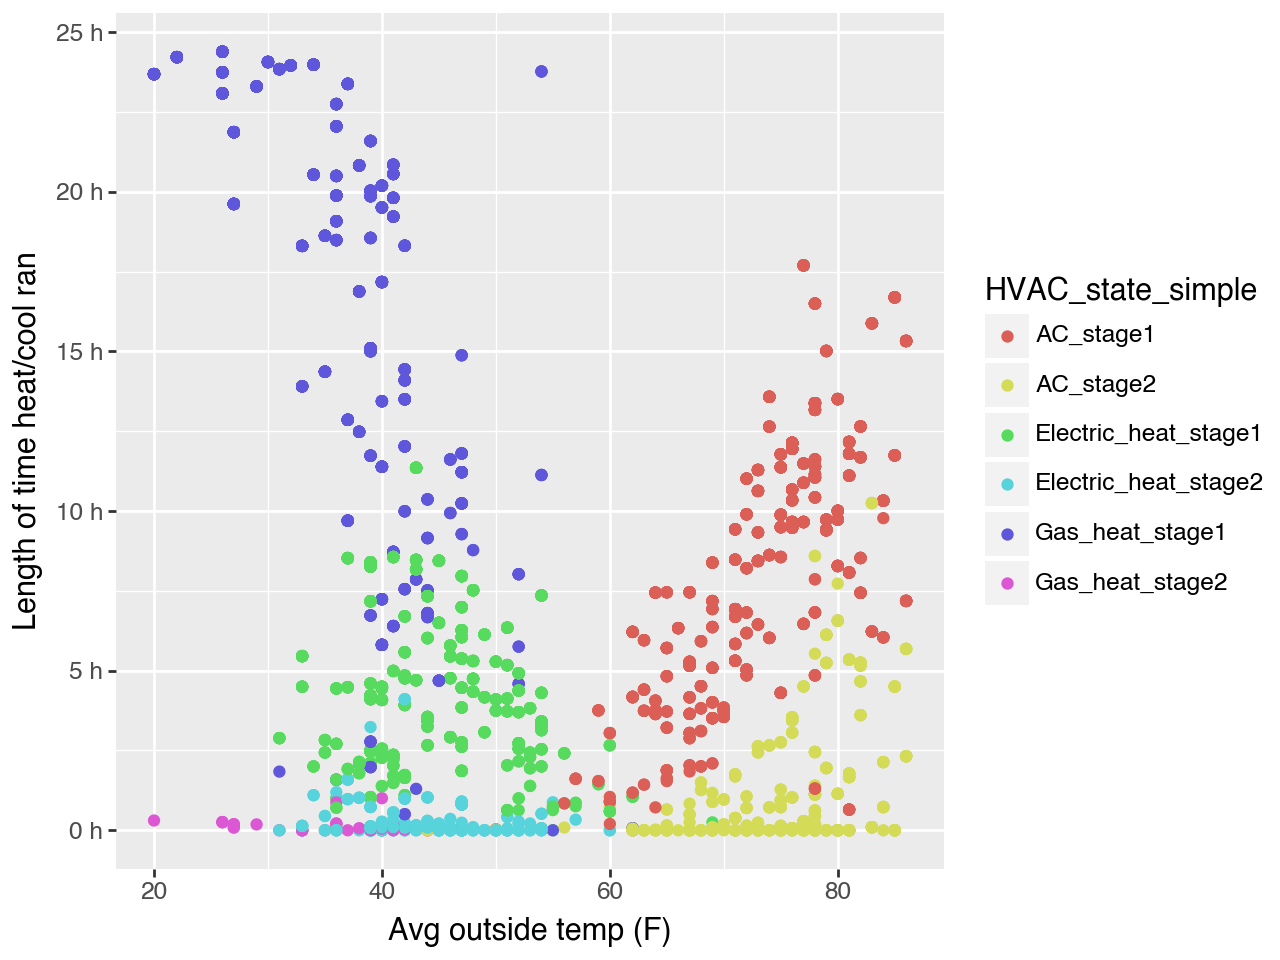

In [200]:
from plotnine import element_text,theme
(ggplot(total_time_tavg_df[ ~total_time_tavg_df.HVAC_state.str.contains("prior")],aes("value","total_time",color="HVAC_state_simple")) + 
 geom_point()+
  ylab("Length of time heat/cool ran")+
 xlab("Avg outside temp (F)")
        )

### Split by heat/cool and shape by stage

/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 41 rows containing missing values.


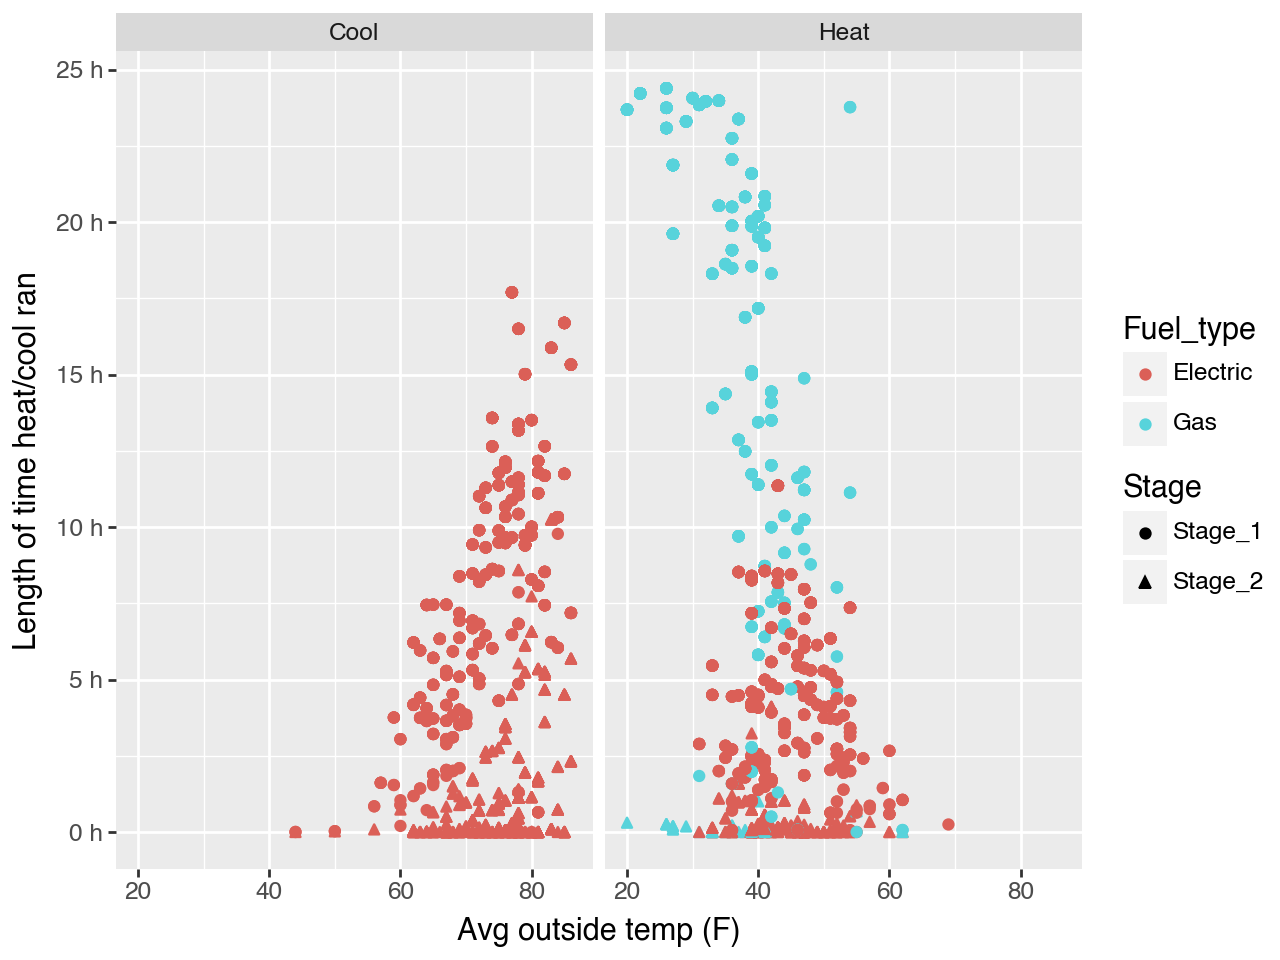

In [201]:
(ggplot(total_time_tavg_df[ ~total_time_tavg_df.HVAC_state.str.contains("prior")],aes("value","total_time",color="Fuel_type",shape="Stage")) + 
 geom_point()+
  ylab("Length of time heat/cool ran")+
 xlab("Avg outside temp (F)")+
 facet_wrap("~HVAV_state")
        )

		

## Date vs temp 
THis is just a sanity check, but also layers the type of HVAC stage (kind of interesting!)

/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 41 rows containing missing values.


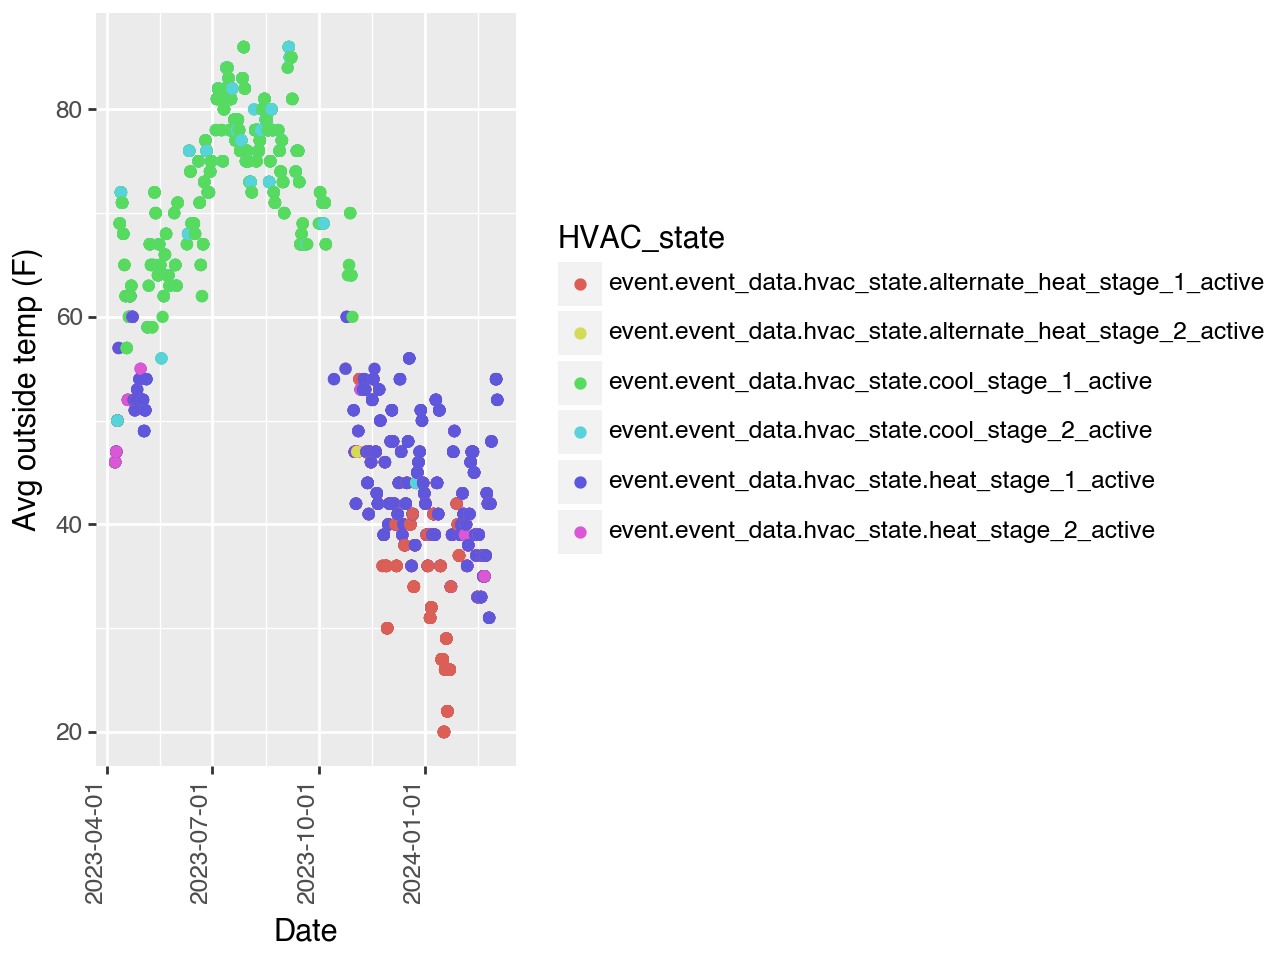

In [203]:
#TODO: standardize these dfs, using different data frames!
(ggplot(detail_use_weather[(detail_use_weather['variable']=="TAVG") & ~detail_use_weather.HVAC_state.str.contains("prior")],aes("DATE","value",color="HVAC_state")) + 
 geom_point()+
 ylab("Avg outside temp (F)")+
 xlab("Date")+
 theme(axis_text_x=element_text(rotation=90, hjust=1))
        )

## Histograms of HVAC states
TODO: use the simple HVAC state names (new df)

/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/stevensmith/Projec

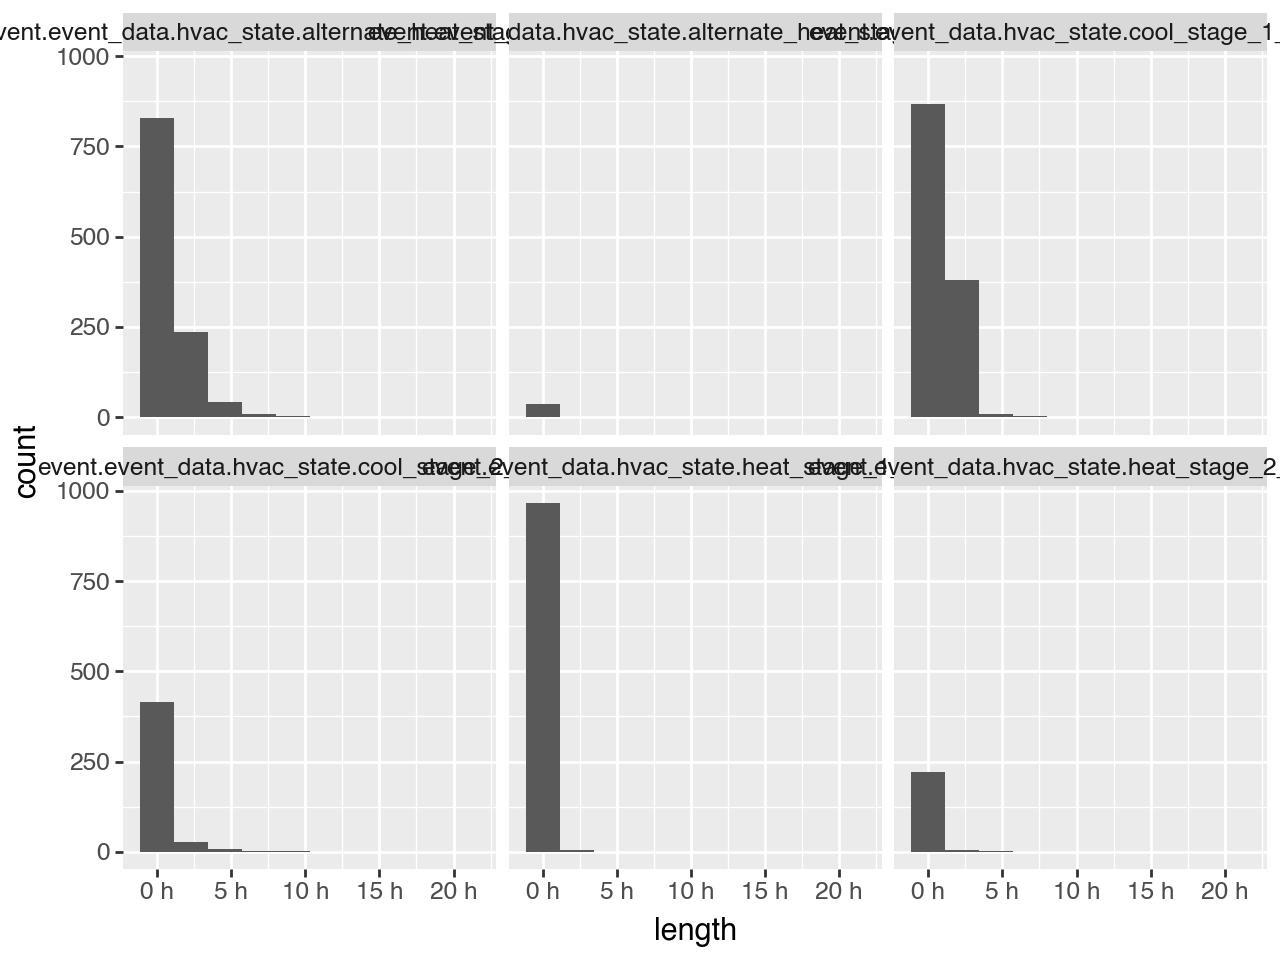

In [167]:

from plotnine import geom_histogram,facet_wrap
(ggplot(detail_use_weather[(detail_use_weather['variable']=="TAVG") & ~detail_use_weather.HVAC_state.str.contains("prior")],aes("length")) + 
 geom_histogram(bins=10)+
 facet_wrap("~HVAC_state")
        )


# Takeaways & Future
* Cooling usage is more than double that of heating usage for a given temp difference (12 mins/degree vs 34 mins/degree for cooling)
* Is there more granular temp data (hourly)?
* Is there a way to add the set point of the thermostat-> this way could ask the question what changing the thermostat has (THERE MAY BE but current json only has like a month)
* Add in pricing info to translate usage into cost
* Add automatically downloading NEST and/or weather data
* Add README on how to obtain NEST and weather data  
* Clean up plots

# Sandbox
